In [58]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pickle
from sklearn.metrics import classification_report
from sklearn.datasets import make_circles, make_moons
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
# 1. Номер группы + 15
# 2. Номер варианта + 56
# 3. ИУ5 (Номер варианта + 21); ГУИМЦ (80); Иностранцы (90)
# (39 — клавиатуры, 58 — небо, 23 — внедорожники)
CLASSES = [39, 58, 23]

# массив
train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES) # фильтруем данные, выбираем только те, которые относятся к нашим классам

train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)

test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

In [60]:
batch_size = 128
dataloader = {}

for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader (из библиотеки torch)

dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x29c18f610>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x295103280>}

In [61]:
class Normalize(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.norm = Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025])
        self.seq = nn.Sequential(
            nn.Linear(32*32*3, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, classes),
        )

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

HIDDEN_SIZE = 32
model = Cifar100_MLP(hidden_size=HIDDEN_SIZE, classes=len(CLASSES))
model

Cifar100_MLP(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [62]:
# Функция потерь
criterion = nn.CrossEntropyLoss()
# оптимизатор — это метод достижения лучших результатов, помощь в ускорении обучения.
# Другими словами, это алгоритм, используемый для незначительного изменения параметров,
# таких как веса и скорость обучения, чтобы модель работала правильно и быстро
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [63]:
EPOCHS = 250
# train data set
steps_per_epoch_train = len(dataloader['train'])
# test data set (валидация)
steps_per_epoch_test = len(dataloader['test'])

losses_train_x = []
losses_train_y = []
losses_test_x = []
losses_test_y = []

for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    running_loss = 0.0
    model.train()

    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        running_loss += loss.item()
    
    #print(f'[{epoch + 1}, {i + 1:5d}] train loss: {running_loss / steps_per_epoch_train:.3f}')

    # график
    losses_train_x.append(epoch)
    losses_train_y.append(running_loss / steps_per_epoch_train)

    running_loss = 0.0
    model.eval() # модель переводится в evaluation mode (режим оценки)
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, batch in enumerate(dataloader['test'], 0):
            inputs, labels = batch

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    #print(f'[{epoch + 1}, {i + 1:5d}] validation loss: {running_loss / steps_per_epoch_train:.3f}')

    # график
    losses_test_x.append(epoch)
    losses_test_y.append(running_loss / steps_per_epoch_test)

print('Обучение закончено')

Обучение закончено


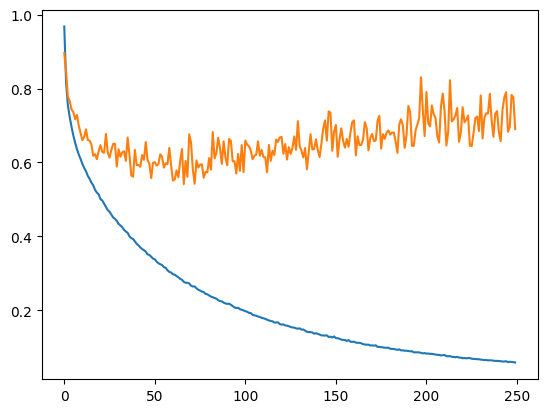

In [64]:
# выводим историю функции потерь по итерациям
plt.plot(losses_train_x, losses_train_y)
plt.plot(losses_test_x, losses_test_y)

min_losses_test_y = max(losses_test_y)
min_losses_test_x = 0
for i in range(0, len(losses_test_y)):
    if losses_test_y[i] < min_losses_test_y:
        min_losses_test_y = losses_test_y[i]
        min_losses_test_x = i

plt.Circle((min_losses_test_x, min_losses_test_y), 10, color='b', fill=False)

In [65]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data

            outputs = model(inputs).detach().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1), digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

          39     0.9960    0.9880    0.9920       500
          58     0.9960    0.9960    0.9960       500
          23     0.9921    1.0000    0.9960       500

    accuracy                         0.9947      1500
   macro avg     0.9947    0.9947    0.9947      1500
weighted avg     0.9947    0.9947    0.9947      1500

--------------------------------------------------
test
              precision    recall  f1-score   support

          39     0.6780    0.8000    0.7339       100
          58     0.7143    0.5500    0.6215       100
          23     0.8000    0.8400    0.8195       100

    accuracy                         0.7300       300
   macro avg     0.7308    0.7300    0.7250       300
weighted avg     0.7308    0.7300    0.7250       300

--------------------------------------------------
